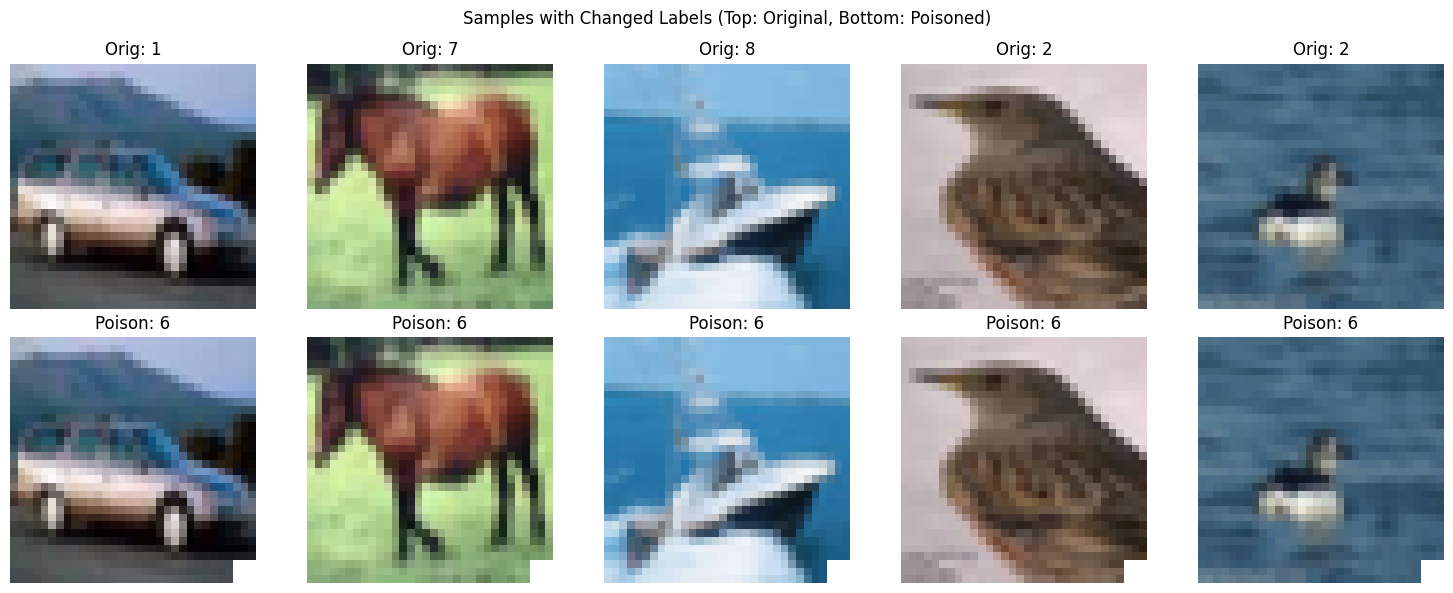

ASR (Attack Success Rate): 100.00%


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches


# =======================
# Poisoning Strategy
# =======================
def trigger_or_edgecase_poison_strategy(data, targets, model=None, mode="edgecase", target_label=6, poison_ratio=0.1):
    data = data.clone()
    targets = targets.clone()

    if mode == "trigger":
        torch.manual_seed(42)
        num_poison = int(poison_ratio * data.size(0))
        poison_indices = torch.randperm(data.size(0))[:num_poison]

        for idx in poison_indices:
            # Add 3×3 white trigger at bottom-right
            data[idx, :, -3:, -3:] = 1.0
            targets[idx] = target_label

    elif mode == "edgecase" and model is not None:
        model.eval()
        with torch.no_grad():
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            confidences = probs.max(dim=1).values
            low_conf_idx = (confidences < 0.5).nonzero(as_tuple=True)[0]

        for idx in low_conf_idx:
            targets[idx] = target_label

    return data, targets

# =======================
# Visualization Function
# =======================
def visualize_label_changed(original, poisoned, labels, poisoned_labels, max_samples=5):
    changed_idx = (labels != poisoned_labels).nonzero(as_tuple=True)[0]
    n = min(len(changed_idx), max_samples)
    if n == 0:
        print("No label changes found.")
        return
    fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
    for i in range(n):
        idx = changed_idx[i]
        axs[0, i].imshow(np.transpose(original[idx].numpy(), (1, 2, 0)))
        axs[0, i].set_title(f"Orig: {labels[idx].item()}")
        axs[0, i].axis("off")
        axs[1, i].imshow(np.transpose(poisoned[idx].numpy(), (1, 2, 0)))
        axs[1, i].set_title(f"Poison: {poisoned_labels[idx].item()}")
        axs[1, i].axis("off")
    plt.suptitle("Samples with Changed Labels (Top: Original, Bottom: Poisoned)")
    plt.tight_layout()
    plt.show()

# =======================
# Simple CNN
# =======================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# =======================
# Training + Evaluation
# =======================
def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_asr(model, test_data, test_labels, target_label):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data.to(device))
        preds = torch.argmax(outputs, dim=1)
        asr = (preds == target_label).float().mean().item()
    return asr

# =======================
# Main
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Subsample for speed
train_data = torch.stack([trainset[i][0] for i in range(200)])
train_labels = torch.tensor([trainset[i][1] for i in range(200)])

# Apply Poisoning
poisoned_data, poisoned_labels = trigger_or_edgecase_poison_strategy(train_data, train_labels, mode="trigger", target_label=6, poison_ratio=0.2)

# Visualize Before vs After
visualize_label_changed(train_data, poisoned_data, train_labels, poisoned_labels)

# Train Model
trainloader = torch.utils.data.DataLoader(
    list(zip(poisoned_data, poisoned_labels)), batch_size=64, shuffle=True
)
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, trainloader, criterion, optimizer)

# Create Poisoned Test Set to Measure ASR
test_data = torch.stack([testset[i][0] for i in range(100)])
test_labels = torch.tensor([testset[i][1] for i in range(100)])
triggered_test, _ = trigger_or_edgecase_poison_strategy(test_data, test_labels, mode="trigger", target_label=6, poison_ratio=0.2)

asr = evaluate_asr(model, triggered_test, test_labels, target_label=6)
print(f"ASR (Attack Success Rate): {asr:.2%}")

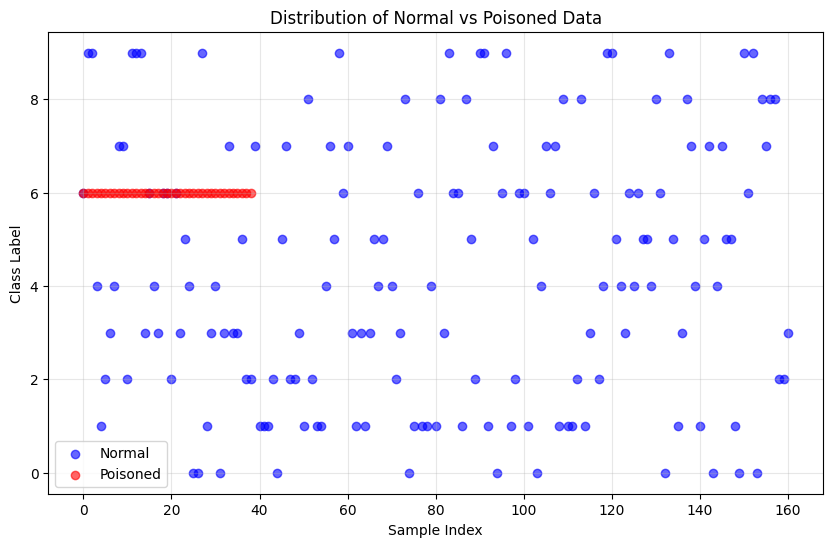

In [2]:
# Create scatter plot to visualize normal vs poisoned data distribution
plt.figure(figsize=(10, 6))
normal_mask = (train_labels == poisoned_labels)
poison_mask = (train_labels != poisoned_labels)

# Plot normal data points
plt.scatter(range(len(train_labels[normal_mask])),
            train_labels[normal_mask],
            c='blue', label='Normal', alpha=0.6)

# Plot poisoned data points 
plt.scatter(range(len(train_labels[poison_mask])),
            poisoned_labels[poison_mask],
            c='red', label='Poisoned', alpha=0.6)

plt.ylabel('Class Label')
plt.xlabel('Sample Index')
plt.title('Distribution of Normal vs Poisoned Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

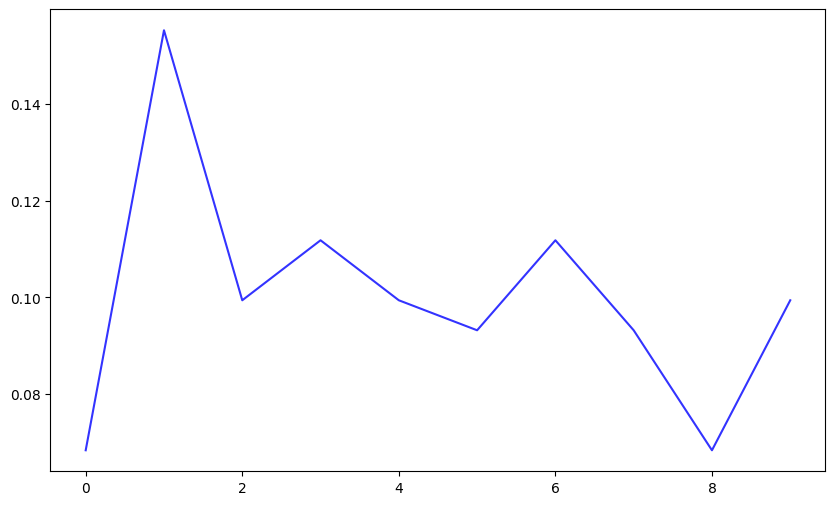

In [3]:
# Create distribution curve plot
plt.figure(figsize=(10, 6))

# Get counts of normal and poisoned labels
normal_counts = np.bincount(train_labels[normal_mask])
poison_counts = np.bincount(poisoned_labels[poison_mask])

# Plot smoothed distributions
x = np.arange(10)  # 10 classes
plt.plot(x, normal_counts / len(train_labels[normal_mask]), 'b-', label='Normal', alpha=0.8)
plt.plot(x, poison_counts / len(poisoned_labels[poison_mask]), 'r-', label='Poisoned', alpha=0.8)

plt.fill_between(x, normal_counts / len(train_labels[normal_mask]), alpha=0.3, color='blue')
plt.fill_between(x, poison_counts / len(poisoned_labels[poison_mask]), alpha=0.3, color='red')

plt.ylabel('Normalized Frequency')
plt.xlabel('Class Label')
plt.title('Distribution of Normal vs Poisoned Labels')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
